### Polynomial Regression

**Polynomial Regression** is one of the easiest way to bring non linearity in linear models. **Polynomial models** are like

$y_i = \beta_0 + \beta_1 * x_i + \beta_1 x_i^2 + ... + \beta_d x_i^d + \epsilon_i$, its linear in $\beta$ but non-linear in $x_i$.

In the notebook below we will use the Boston housing data and apply polynomial features to some Xs and use LASSO for model selection and see if we can beat simple linear regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

%matplotlib inline

In [2]:
#Import boston dataset
from sklearn import datasets

#Load data in a dataframe
boston_data = datasets.load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_boston.drop('target', axis=1), df_boston['target'].values, test_size=0.20, random_state=1)

print(f"Size of test set = {y_test.shape[0]}")
print(f"Size of train set = {y_train.shape[0]}")

Size of test set = 102
Size of train set = 404


In [3]:
#Lets first standardize the X
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

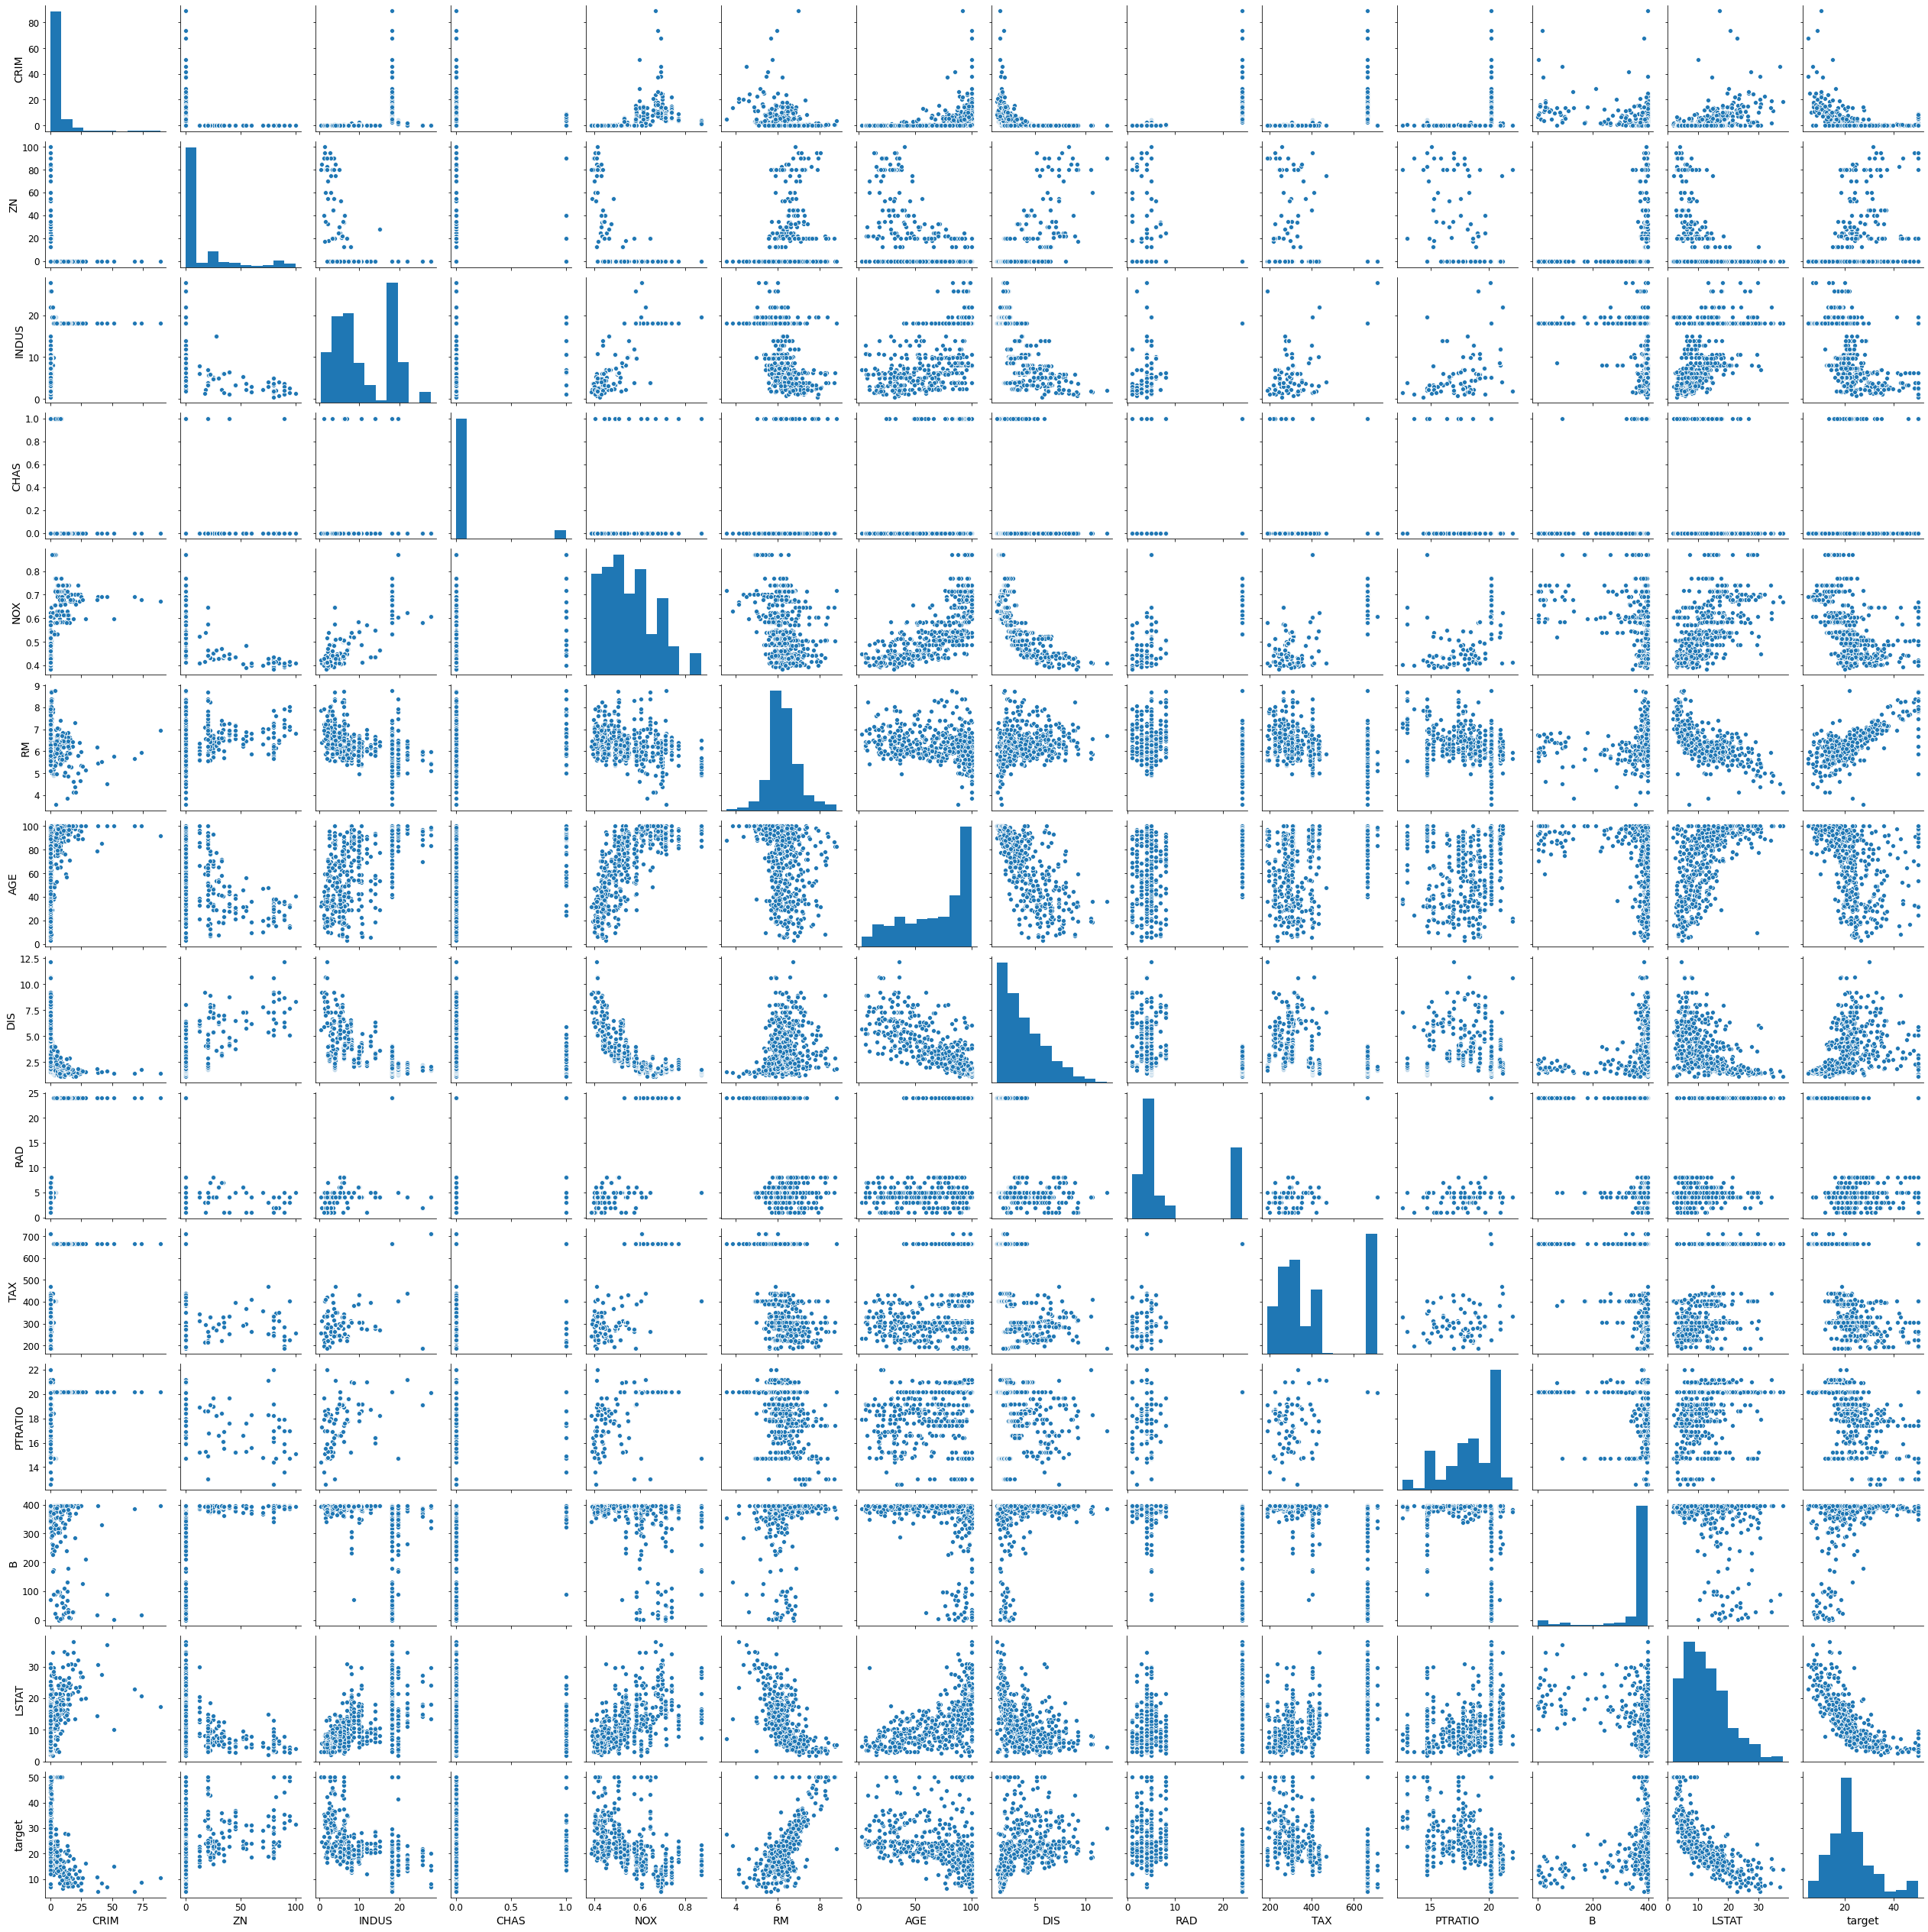

In [4]:
#Lets do basic plotting
import seaborn as sns
sns.pairplot(df_boston)

In [5]:
#Lets fit a simple linear model
from sklearn import linear_model
reg = linear_model.LinearRegression().fit(X_train_std, y_train)
print(f"Linear Regression Score = {reg.score(X_test_std, y_test):.3}")

Linear Regression Score = 0.763


In [6]:
#Now lets apply LASSO
#Now lets select LASSO regularization paramter by k fold cross validation and grid search
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
pipe_lasso = make_pipeline(StandardScaler(),
                       linear_model.Lasso())
param_range = np.logspace(-4, 5, 10)
param_grid = [{'lasso__alpha': param_range}]
gs = GridSearchCV(estimator=pipe_lasso, param_grid=param_grid, cv=10, refit=True)
gs = gs.fit(X_train, y_train)

print(f"Best score = {gs.best_score_:.3}")
print(gs.best_params_)

#Fit the model with best_params on total train set
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train_std, y_train)
#Evaluate on test set
print(f"Test score {lasso.score(X_test_std, y_test):.3}")
print("Coef =",lasso.coef_, "Intercept =", lasso.intercept_)

Best score = 0.678
{'lasso__alpha': 0.01}
Test score 0.763
Coef = [-0.9983405   1.29179138  0.0293823   0.57751155 -2.20111044  2.14912818
  0.08147219 -3.13152924  2.44533716 -1.6798403  -2.12152258  0.65886303
 -3.90139041] Intercept = 22.522277227722775


In [7]:
#Now lets add polynomial features upto degree 4 for non categorical variables
class PolyFeatures:
    def __init__(self, degree):
        self.degree = degree
        
    def fit_transform(self, X):
        X_ret = X.copy()
        for d in range(2, self.degree+1):
            X_d = np.power(X, d)
            X_ret = np.hstack((X_ret, X_d))
        return X_ret
    
poly = PolyFeatures(4)
columnsToApplyPolyFeatures = [4, 7, 12]
columnsToNotApplyPolyFeatures = [0,1,2,3,5,6, 8,9,10,11]
X_train_poly_std = poly.fit_transform(X_train_std[:,columnsToApplyPolyFeatures])
X_train_poly_std = np.hstack((X_train_poly_std, X_train_std[:,columnsToNotApplyPolyFeatures]))

X_test_poly_std = poly.fit_transform(X_test_std[:,columnsToApplyPolyFeatures])
X_test_poly_std = np.hstack((X_test_poly_std, X_test_std[:,columnsToNotApplyPolyFeatures]))

pipe_lasso = make_pipeline(StandardScaler(),
                       linear_model.Lasso(max_iter=100000))
param_range = np.logspace(-4, 5, 10)
param_grid = [{'lasso__alpha': param_range}]

gs = GridSearchCV(estimator=pipe_lasso, param_grid=param_grid, cv=10, refit=True)
gs = gs.fit(X_train_poly_std, y_train)

print(f"Best score = {gs.best_score_:.3}")
print(gs.best_params_)

#Fit the model with best_params on total train set
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train_poly_std, y_train)

#Evaluate on test set
print(f"Test score {lasso.score(X_test_poly_std, y_test):.3}")
print("Coef =",lasso.coef_, "Intercept =", lasso.intercept_)

Best score = 0.747
{'lasso__alpha': 0.01}
Test score 0.843
Coef = [-1.22332094 -2.68663412 -3.51874777 -1.55918884  1.81144221  1.61909965
 -0.44217672 -0.8042881  -1.73220182  0.31753498  0.11571988  0.45739807
 -1.61329499  0.14771593 -0.46715693  0.64135094  1.79394627  0.05265329
  2.79336182 -1.82538807 -1.77733477  0.59452491] Intercept = 20.437210352950913


####  We can see by applying polynomial features to couple of xs we improved our test score to 84.3%